# Lab: Deep Domain Adaptation

<a href="https://creativecommons.org/licenses/by-nc/4.0/">
  <img src="https://licensebuttons.net/l/by-nc/4.0/88x31.png" alt="CC BY-NC 4.0" style="vertical-align:middle;">
</a>
<span style="vertical-align:middle; margin-left:8px;">
  <strong>CC BY‑NC 4.0</strong> — non‑commercial use with attribution.  
  Full terms at the link.
</span>

<br>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/antoninofurnari/deeplearning/blob/main/notebooks/09-04-26-deep-domain-adaptation.ipynb
)

**Course:** Deep Learning: Advanced Models and Methods

**Instructor:** Antonino Furnari

**Duration:** 2 Hours (In-class Group Lab)

## 📝 Lab Format & Deliverables
* **Format:** 
  * Students work in groups of 1-3.
  * The teacher gives a brief introduction to the lab, then students work independently with support from the teacher.
* **Strategy:** 
  * Fill in the ☑️ `TODO` blocks. Do not modify the provided boilerplate unless necessary.
  * Check that you obtained reasonable results through the 🛑 `Checkpoints`.
  * Fill in the short 📝 `Reflections` where required.
  * Reach 🏁 `Milestones`.
* **Submission:**
  * Fill in this notebook and send it to <antonino.furnari@unict.it> as an `.ipynb` by the end of the lab
* **Grading:**
  * Notebooks will be graded in binary way as passed / not passed based on completion (did the group reach all milestones successfully? are reflections adequate?)
  * Each notebook is worth $0.5$ bonus points. These are assigned to students individually (not to groups).
* **Computation:**
  * Run this notebook on Google Colab or Kaggle with GPU acceleration.

You will find the following blocks throughout the notebook:

<div class="alert alert-block alert-info">
<b>☑️ TODO</b> This box provides you instruction on a TODO that should be completed in the code cells below.
</div>

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint</b> The following cells provide you instruction on what you should observe if you run a given cell after having implemented your TODOs. This serve as a self-check to assess potential bugs or errors early.
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection</b> You are required to write a short reflection on your results.
</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone</b> This signal that you completed a significant part of the notebook and reached a milestone.
</div>

## Your Data
<div class="alert alert-block alert-warning">
<b>📝 Date and Team Composition</b>

<i>Insert the current date, plus names, surnames, matricola, and emails of the team members below:</i>

**Date:** YYYY-MM-DD

**Link to wandb:** <a href="example_link">link</a>

| Name | Surname | Matricola | Email |
|---|---:|---:|---|
| Name 1 | Surname1 | 0000001 | <a href="mailto:member1@example.com">member1@example.com</a> |
| Name 2 | Surname2 | 0000002 | <a href="mailto:member2@example.com">member2@example.com</a> |
| Name 3 | Surname3 | 0000003 | <a href="mailto:member3@example.com">member3@example.com</a> |
</div>

## Introduction and Problem Setup

**Objective:** In this lab, you will implement Unsupervised Domain Adaptation (UDA) to transfer knowledge from a labeled source domain (MNIST) to an unlabeled target domain (MNIST-M) using a **Gradient Reversal Layer (GRL)**.

**Agenda:**
1.  **The Setup:** Load MNIST (Source) and MNIST-M (Target).
2.  **The Bounds:** Establish the Baseline (Failure) and the Oracle (Upper Bound).
3.  **The Diagnosis:** Visualize the domain shift using t-SNE.
4.  **The Solution:** Implement GRL to align feature distributions.

### Problem Setup
We will consider the problem of classifying images belonging to two domains: a source domain and a target domain. Images from the source domain are labeled, while those from the target domain are unlabeled. Both domains share the same label space. The objective is to train a model capable of training on labeled images from the source domain and unlabeled images from the target domain, and to perform well at test time on images from both domains. This setup is called unsupervised domain adaptation because the images from the target domain are unlabeled and therefore the adaptation is unsupervised.

### The Data
We will consider two datasets: MNIST and MNIST-M. MNIST-M is created by combining MNIST digits with the patches randomly extracted from color photos of BSDS500 as their background. It contains 59,001 training and 90,001 test images.

Here are some examples:

<img src="https://www.antoninofurnari.it/downloads/mnist-vs-mnistm.png">


## Preparation

We will start by installing necessary packages and making imports.

In [1]:
# Install necessary libraries
!pip install pytorch-lightning wandb torchmetrics -q

import os
import errno
import urllib.request
import gzip
import pickle
import random
from datetime import datetime
from typing import Tuple, Optional, List, Dict, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.autograd import Function
from PIL import Image
from sklearn.manifold import TSNE

# PyTorch Lightning & WandB
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
import torchmetrics
import wandb

# Configuration
NUM_EPOCHS = 10      # Reduced for Lab Session. Recommended: 50
BATCH_SIZE = 256
NUM_WORKERS = 2     # Safe for Colab
LEARNING_RATE = 1e-3
TSNE_SAMPLES = 500  # Smaller sample for speed

# Set global seed for reproducibility
pl.seed_everything(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup complete. Using device: {device}")

# Weights & Biases Login
WANDB_PROJECT = "dl-lab-domain-adaptation"
print("\n🚀 Logging in to Weights & Biases...")
try:
    # This will prompt you for your API key if not already logged in
    wandb.login()
    print(f"✅ Login successful! Runs will be logged to project: '{WANDB_PROJECT}'")
except Exception as e:
    print(f"⚠️ Login failed: {e}")
    print("⚠️ Switching to OFFLINE mode. Metrics will be saved locally.")
    os.environ["WANDB_MODE"] = "offline"

Seed set to 42


✅ Setup complete. Using device: cuda

🚀 Logging in to Weights & Biases...


wandb: Currently logged in as: antoninofurnari. Use `wandb login --relogin` to force relogin


✅ Login successful! Runs will be logged to project: 'dl-lab-domain-adaptation'


Let's define some visualization and metrics utilities:

In [2]:
# ==========================================
# 📊 VISUALIZATION & METRICS UTILITIES
# ==========================================

class MetricHistoryCallback(Callback):
    """
    Custom callback to store metrics locally for plotting at the end of training.
    """
    def __init__(self):
        super().__init__()
        self.history = {}

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        for k, v in metrics.items():
            if k not in self.history: self.history[k] = []
            # Handle tensors vs floats
            val = v.item() if isinstance(v, torch.Tensor) else v
            self.history[k].append(val)

def plot_training_curves(history, title="Training Curves"):
    """
    Plots Loss and Accuracy from the local history.
    """
    # Check if history is empty
    if not history:
        print("No metrics to plot.")
        return

    epochs = range(1, len(next(iter(history.values()))) + 1)
    plt.figure(figsize=(12, 5))
    
    # 1. Plot Loss
    plt.subplot(1, 2, 1)
    for k, v in history.items():
        if 'loss' in k and 'epoch' not in k: # Filter simple keys
            plt.plot(epochs, v, label=k)
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 2. Plot Accuracy (if available)
    plt.subplot(1, 2, 2)
    has_acc = False
    for k, v in history.items():
        if 'acc' in k:
            plt.plot(epochs, v, label=k)
            has_acc = True
    if has_acc:
        plt.title(f'{title} - Accuracy')
        plt.xlabel('Epoch')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_tsne(feature_extractor, loader_source, loader_target, device, title="t-SNE"):
    """
    Extracts features from both domains and plots them using t-SNE.
    """
    feature_extractor.to(device)
    feature_extractor.eval()
    
    features, domains, labels = [], [], []

    # 1. Extract Source
    for x, y in loader_source:
        x = x.to(device)
        with torch.no_grad():
            feats = feature_extractor(x).view(x.shape[0], -1)
        features.append(feats.cpu())
        domains.append(torch.zeros(x.size(0))) # Domain 0
        labels.append(y)
        if len(features) * BATCH_SIZE > TSNE_SAMPLES: break

    # 2. Extract Target
    for x, y in loader_target:
        x = x.to(device)
        with torch.no_grad():
            feats = feature_extractor(x).view(x.shape[0], -1)
        features.append(feats.cpu())
        domains.append(torch.ones(x.size(0))) # Domain 1
        labels.append(y)
        if len(features) * BATCH_SIZE > 2 * TSNE_SAMPLES: break 

    # Concatenate
    features = torch.cat(features, dim=0).numpy()
    domains = torch.cat(domains, dim=0).numpy()
    
    # Run t-SNE [Image of t-SNE distribution shift]
    print(f"Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[domains==0, 0], embeddings[domains==0, 1], c='blue', alpha=0.4, label='Source (MNIST)', s=10)
    plt.scatter(embeddings[domains==1, 0], embeddings[domains==1, 1], c='red', alpha=0.4, label='Target (MNIST-M)', s=10)
    plt.legend()
    plt.title(title)
    plt.show()

Let's now load the data. We will use [this implementation](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cogan/mnistm.py):

Loading Datasets...


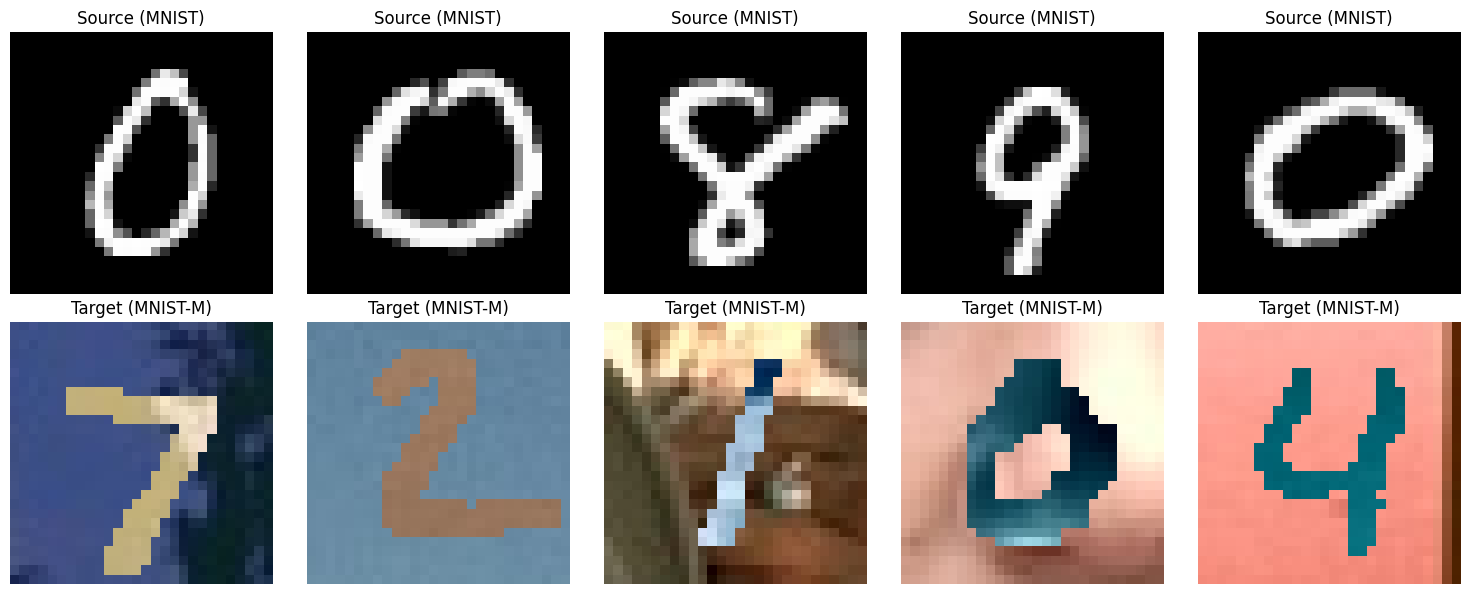

In [11]:
class MNISTM(Dataset):
    """
    MNIST-M Dataset (MNIST on colored backgrounds).
    Downloads and processes the dataset automatically.
    """
    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"
    raw_folder = "raw"
    processed_folder = "processed"
    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"

    def __init__(self, root: str, mnist_root: str = "data", train: bool = True, 
                 transform: Optional[transforms.Compose] = None, 
                 download: bool = False):
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.train = train 

        if download: self.download()
        if not self._check_exists():
            raise RuntimeError("Dataset not found. Use download=True to download it.")

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file)
            )
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file)
            )

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
        
        # Convert to PIL for consistency
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")
        if self.transform is not None: img = self.transform(img)
        return img, target

    def __len__(self) -> int:
        return len(self.train_data) if self.train else len(self.test_data)

    def _check_exists(self) -> bool:
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file))

    def download(self):
        if self._check_exists(): return
        os.makedirs(os.path.join(self.root, self.raw_folder), exist_ok=True)
        os.makedirs(os.path.join(self.root, self.processed_folder), exist_ok=True)
        
        print("Downloading " + self.url)
        filename = self.url.rpartition("/")[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        
        if not os.path.exists(file_path.replace(".gz", "")):
            data = urllib.request.urlopen(self.url)
            with open(file_path, "wb") as f: f.write(data.read())
            with open(file_path.replace(".gz", ""), "wb") as out_f, gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        print("Processing...")
        with open(file_path.replace(".gz", ""), "rb") as f:
            mnist_m_data = pickle.load(f, encoding="bytes")
        mnist_m_train_data = torch.tensor(mnist_m_data[b"train"], dtype=torch.uint8)
        mnist_m_test_data = torch.tensor(mnist_m_data[b"test"], dtype=torch.uint8)
        
        # Get labels from original MNIST
        mnist_train_labels = datasets.MNIST(root=self.mnist_root, train=True, download=True).targets
        mnist_test_labels = datasets.MNIST(root=self.mnist_root, train=False, download=True).targets
        
        torch.save((mnist_m_train_data, mnist_train_labels), os.path.join(self.root, self.processed_folder, self.training_file))
        torch.save((mnist_m_test_data, mnist_test_labels), os.path.join(self.root, self.processed_folder, self.test_file))
        print("Done!")

# Transforms: Standardize to [-1, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 1. Load Datasets
print("Loading Datasets...")
mnist_train = datasets.MNIST('data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST('data', train=False, transform=transform, download=True)
mnistm_train = MNISTM('data', train=True, transform=transform, download=True)
mnistm_test = MNISTM('data', train=False, transform=transform, download=True)

# 2. Create Loaders
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
mnist_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
mnistm_train_loader = DataLoader(mnistm_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
mnistm_test_loader = DataLoader(mnistm_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# 3. Visualize
def show_examples(loader_s, loader_t, num=5):
    s_batch = next(iter(loader_s))[0]
    t_batch = next(iter(loader_t))[0]
    fig, axes = plt.subplots(2, num, figsize=(15, 6))
    def denorm(x): return x * 0.5 + 0.5 # Reverse norm for plotting
    
    for i in range(num):
        axes[0, i].imshow(np.clip(denorm(s_batch[i]).permute(1,2,0).numpy(), 0, 1))
        axes[0, i].set_title("Source (MNIST)")
        axes[0, i].axis('off')
        axes[1, i].imshow(np.clip(denorm(t_batch[i]).permute(1,2,0).numpy(), 0, 1))
        axes[1, i].set_title("Target (MNIST-M)")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

show_examples(mnist_train_loader, mnistm_test_loader)

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 1</b> Are you visualizing the same as in the reference notebook?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 1</b> 

<i>Look at the images above. The digits are the same shapes (structural features), but the backgrounds are wildly different (texture/color features). 
  <br><br>
  <strong>Question:</strong> If a standard CNN learns to classify the top row (MNIST), why might it fail on the bottom row (MNIST-M)?</i>

Your text

</div>

# Part 1: Establishing Bounds (Baseline vs. Oracle)

Before we try to solve the problem, we must define the scope of our performance.

1.  **The Baseline (Lower Bound):** Train on Source (MNIST), Test on Target (MNIST-M). This simulates "Naive Transfer."
2.  **The Oracle (Upper Bound):** Train on Target (MNIST-M), Test on Target (MNIST-M). This simulates the ideal scenario where we have labels for the target domain.

Our Goal with Domain Adaptation is to beat the **Baseline** and approach the **Oracle**.

Let's define our backbone network:

In [4]:
class Net(nn.Module):
    """
    Standard CNN Feature Extractor + Classifier.
    """
    def __init__(self):
        super().__init__()
        # Feature Extractor (The part we want to be domain-invariant later)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5), # 3 input channels (RGB)
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        # Classifier (The part that makes decisions)
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

<div class="alert alert-info">
  <strong>☑️ TODO 1: Define the Baseline Task</strong><br>
  Complete the ClassificationTask class below. This is a standard supervised training loop.
</div>

In [ ]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # < YOUR CODE HERE >
        # Implement the training step to compute loss and log training accuracy
        # Use train/loss and train/acc as metric names
        
        # </ YOUR CODE HERE >
        return loss

    def test_step(self, batch, batch_idx):
        # < YOUR CODE HERE >
        # Implement the test step to compute and log test accuracy
        # Use test/acc as metric name
        
        # </ YOUR CODE HERE >

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

### 1.1 Training the Baseline (Source Only)
We train on **MNIST** and test on **MNIST-M**.

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


🚀 Training Baseline on MNIST...


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ Net                │ 22.3 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 22.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


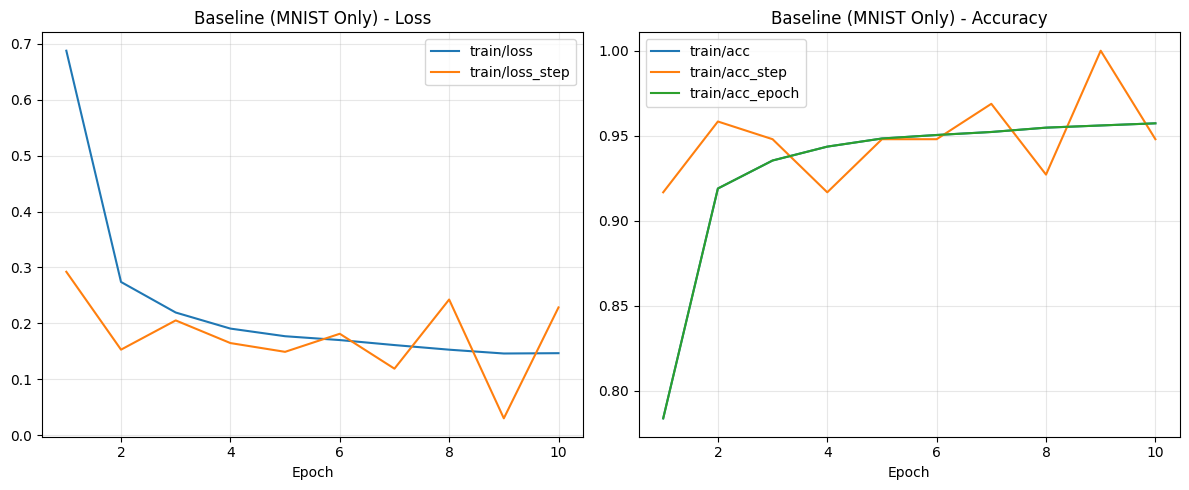

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



📝 Testing Baseline on Target (MNIST-M)...


Output()

Baseline Accuracy: 0.6443


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


In [7]:
# Initialize Model & Callback
baseline_model = Net()
task_baseline = ClassificationTask(baseline_model)
history_base = MetricHistoryCallback()

# Logger
logger_base = WandbLogger(project="domain_adaptation_lab", name=f"baseline")

# Trainer
trainer_base = pl.Trainer(
    max_epochs=NUM_EPOCHS, 
    accelerator="auto",
    logger=logger_base,
    callbacks=[history_base],
    enable_checkpointing=False
)

# Train on MNIST
print("🚀 Training Baseline on MNIST...")
trainer_base.fit(task_baseline, mnist_train_loader)

# --- PLOT CURVES ---
plot_training_curves(history_base.history, title="Baseline (MNIST Only)")

# Test
print("\n📝 Testing Baseline on Target (MNIST-M)...")
res_target = trainer_base.test(task_baseline, dataloaders=mnistm_test_loader, verbose=False)
acc_baseline = res_target[0]['test/acc']
print(f"Baseline Accuracy: {acc_baseline:.4f}")

wandb.finish()

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 2</b> Compare training curves and final metrics. Are they similar to the ones reported in the reference notebook?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 2</b> 

<i>What are these results telling us? Where is the model obtaining its best performance? Why? Is there a gap between source and target domains? Why?</i>

Your text

</div>

Let's now visualize the feature space with t-SNE:

Running t-SNE on 1024 samples...


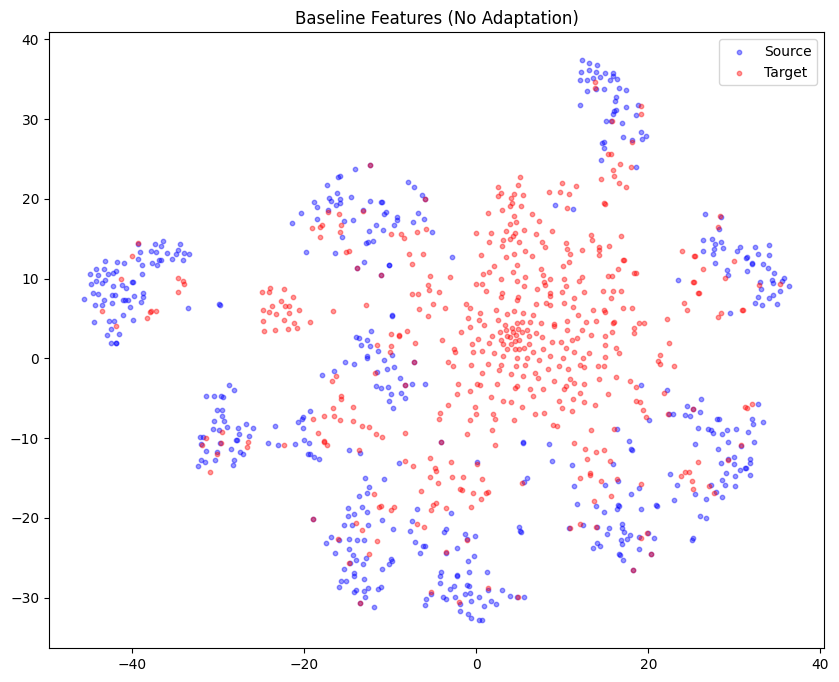

In [8]:
def visualize_tsne(feature_extractor, loader_source, loader_target, device, title="t-SNE"):
    """
    Extracts features from both domains and plots them using t-SNE.
    """
    feature_extractor.to(device)
    feature_extractor.eval()
    
    features, domains, labels = [], [], []

    # 1. Extract Source
    for x, y in loader_source:
        x = x.to(device)
        with torch.no_grad():
            feats = feature_extractor(x).view(x.shape[0], -1)
        features.append(feats.cpu())
        domains.append(torch.zeros(x.size(0))) # Domain 0
        labels.append(y)
        if len(features) * BATCH_SIZE > TSNE_SAMPLES: break

    # 2. Extract Target
    for x, y in loader_target:
        x = x.to(device)
        with torch.no_grad():
            feats = feature_extractor(x).view(x.shape[0], -1)
        features.append(feats.cpu())
        domains.append(torch.ones(x.size(0))) # Domain 1
        labels.append(y)
        if len(features) * BATCH_SIZE > 2 * TSNE_SAMPLES: break # Stop after enough samples

    # Concatenate
    features = torch.cat(features, dim=0).numpy()
    domains = torch.cat(domains, dim=0).numpy()
    
    # Run t-SNE 
    print(f"Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(10, 8))
    # Plot Source (Blue)
    plt.scatter(embeddings[domains==0, 0], embeddings[domains==0, 1], c='blue', alpha=0.4, label='Source', s=10)
    # Plot Target (Red)
    plt.scatter(embeddings[domains==1, 0], embeddings[domains==1, 1], c='red', alpha=0.4, label='Target', s=10)
    plt.legend()
    plt.title(title)
    plt.show()

# Run Visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_tsne(baseline_model.feature_extractor, mnist_test_loader, mnistm_test_loader, device, "Baseline Features (No Adaptation)")

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 3</b> Compare the visualizations to the reference notebook. Are they similar?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 3</b> 

<i>What are the visualizations telling us? Are they coherent with the quantitative results? What is happening? Why?</i>

Your text

</div>

### 1.2 Training the Oracle (Target Supervised)
Now, purely for comparison, we train on **labeled MNIST-M**. This tells us the maximum possible performance of our architecture on this data.

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


🚀 Training Oracle on MNIST-M...


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ Net                │ 22.3 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 22.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


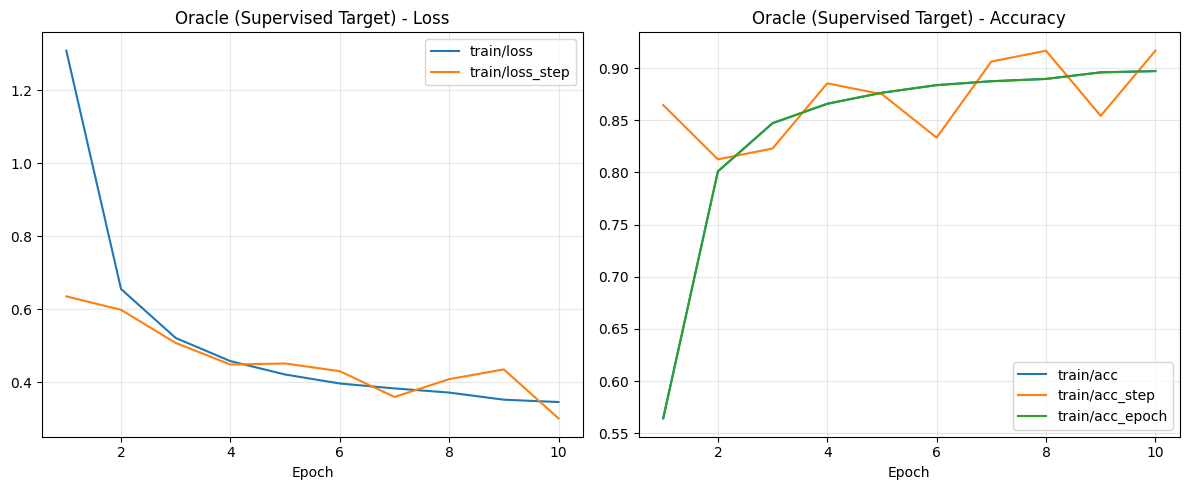

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



📝 Testing Oracle on Target (MNIST-M)...


Output()

Oracle Accuracy: 0.9521


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


In [12]:
# Initialize Model (Reset weights)
oracle_model = Net()
task_oracle = ClassificationTask(oracle_model)
history_oracle = MetricHistoryCallback()

# Logger
logger_oracle = WandbLogger(project="domain_adaptation_lab", name=f"oracle")

# Trainer
trainer_oracle = pl.Trainer(
    max_epochs=NUM_EPOCHS, 
    accelerator="auto",
    logger=logger_oracle,
    callbacks=[history_oracle],
    enable_checkpointing=False
)

# Train on MNIST-M (We pretend we have labels here)
print("🚀 Training Oracle on MNIST-M...")
trainer_oracle.fit(task_oracle, mnistm_train_loader) 

# --- PLOT CURVES ---
plot_training_curves(history_oracle.history, title="Oracle (Supervised Target)")

# Test
print("\n📝 Testing Oracle on Target (MNIST-M)...")
res_oracle = trainer_oracle.test(task_oracle, dataloaders=mnistm_test_loader, verbose=False)
acc_oracle = res_oracle[0]['test/acc']

print(f"Oracle Accuracy: {acc_oracle:.4f}")
wandb.finish()

<div class="alert alert-info">
  <strong>☑️ TODO 2: Plot the t-SNE visualizations.</strong><br>
  Use the functions we defined before to plot the t-SNE visualizations.
</div>

Running t-SNE on 1024 samples...


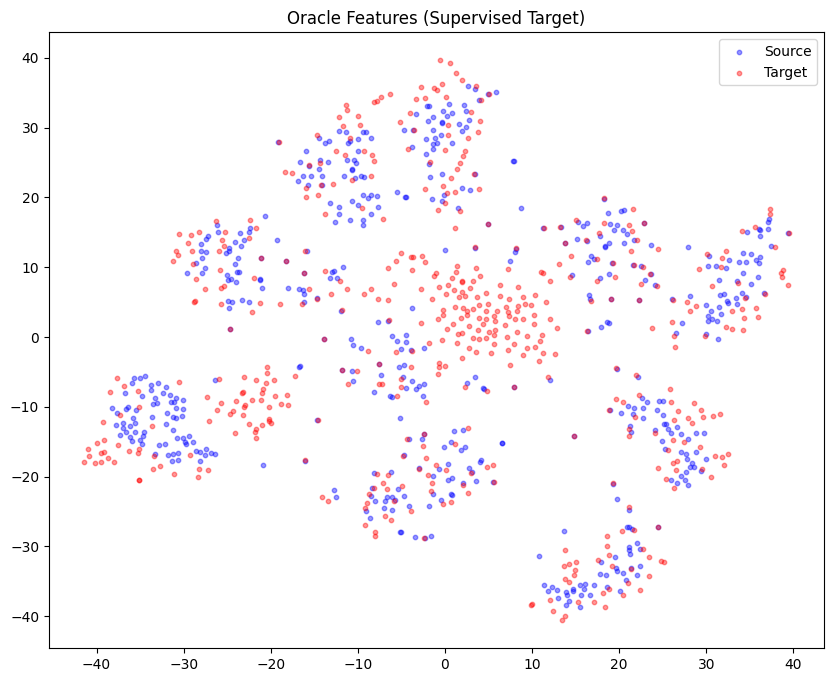

In [ ]:
# plot t-SNE for Oracle
# < YOUR CODE HERE >

# </ YOUR CODE HERE >

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 4</b> Compare the visualizations to the reference notebook. Are they similar?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 4</b> 

<i>What are the visualizations telling us? Are they coherent with the quantitative results? What is happening? Why?</i>

Your text

</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone 1</b> You successfully completed the first part!
</div>

# Part 2: Gradient Reversal Layer (GRL)

To fix this, we need to train the feature extractor to be:
1.  **Discriminative** for the main task (Classify digits).
2.  **Confused** about the domain (Can't tell Source from Target).

We achieve this via a **Gradient Reversal Layer**. In the forward pass, it's identity. In the backward pass, it flips the gradient sign: $\frac{\partial L_d}{\partial \theta_f} = - \lambda \frac{\partial L_d}{\partial \theta_d}$.

<div class="alert alert-info">
  <strong>☑️ TODO 3: Implement the Gradient Reversal.</strong><br>
  Fill in the backward method for the Autograd function below.
</div>

In [ ]:
class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_, lambda_):
        ctx.lambda_ = lambda_
        return input_

    @staticmethod
    def backward(ctx, grad_output):
        # < YOUR CODE HERE >
        # Implement the gradient reversal
        # grad_input should be the negative of grad_output multiplied by lambda_
        
        
        
        # </ YOUR CODE HERE >
        return grad_input, None

# Helper wrapper
def revgrad(x, lambda_):
    return RevGrad.apply(x, lambda_)

Let's define a `MultiDomainDataset` class that we will be using during training:

In [15]:
class MultiDomainDataset(Dataset):
    def __init__(self, source_ds, target_ds):
        self.source = source_ds
        self.target = target_ds
    def __len__(self): return len(self.source)
    def __getitem__(self, idx):
        src_img, src_label = self.source[idx]
        # Random sample from target
        tgt_img, _ = self.target[random.randint(0, len(self.target)-1)]
        return src_img, tgt_img, src_label

# Create paired loader
train_paired = MultiDomainDataset(mnist_train, mnistm_train)
train_paired_loader = DataLoader(train_paired, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Let's now define the Lightning DomainAdaptationTask module:

<div class="alert alert-info">
  <strong>☑️ TODO 4: Fill in the missin parts of the DomainAdaptationTask class below.</strong><br>
</div>

In [ ]:
class DiscriminatorGRL(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorGRL, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
    )

    def forward(self, x):
        return self.model(x)
    
class DomainAdaptationTask(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        self.discriminator = DiscriminatorGRL()
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        source_img, target_img, source_labels = batch
        
        # 1. Calculate Lambda (Scheduler)
        p = self.current_epoch / self.trainer.max_epochs
        # < YOUR CODE HERE >
        # Implement the lambda calculation as per the paper
        
        # </ YOUR CODE HERE >
        
        # 2. Extract Features
        src_feat = self.model.feature_extractor(source_img).view(source_img.size(0), -1)
        tgt_feat = self.model.feature_extractor(target_img).view(target_img.size(0), -1)
        
        # 3. Class Prediction (Source Only)
        class_preds = self.model.classifier(src_feat)
        loss_class = F.cross_entropy(class_preds, source_labels)
        
        # 4. Domain Prediction (With GRL!)
        # Apply RevGrad to features before passing to discriminator
        src_feat_rev = revgrad(src_feat, lambda_)
        tgt_feat_rev = revgrad(tgt_feat, lambda_)
        
        domain_pred_src = self.discriminator(src_feat_rev)
        domain_pred_tgt = self.discriminator(tgt_feat_rev)
        
        # Prepare labels (0 for Source, 1 for Target)
        y_src = torch.zeros(source_img.size(0), 1).type_as(source_img)
        y_tgt = torch.ones(target_img.size(0), 1).type_as(target_img)
        
        # < YOUR CODE HERE >
        # Implement the domain loss calculation using binary cross entropy
        
        # </ YOUR CODE HERE >
        
        # Discriminator Accuracy
        acc_disc = 0.5 * ((domain_pred_src.sigmoid() >= 0.5).float().eq(y_src).sum().item() / y_src.size(0) +
                       (domain_pred_tgt.sigmoid() < 0.5).float().eq(y_tgt).sum().item() / y_tgt.size(0))
        
        # Total Loss
        loss = loss_class + loss_domain
        
        self.log('train/loss_total', loss)
        self.log('train/loss_domain', loss_domain)
        self.log('train/loss_class', loss_class)
        self.log('train/acc_disc', acc_disc)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.accuracy(logits, y)
        self.log('test/acc', self.accuracy, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(list(self.model.parameters()) + list(self.discriminator.parameters()), lr=LEARNING_RATE)

<div class="alert alert-block alert-warning">
<b>📝 Reflection 5</b> 

<i>Inspect the two cells above and describe in your own words what they allow us to do.</i>

Your text

</div>

### 3.1 Training with GRL
Now we train the new model.

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


🚀 Training GRL...


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Net                │ 22.3 K │ train │     0 │
│ 1 │ discriminator │ DiscriminatorGRL   │ 17.1 K │ train │     0 │
│ 2 │ accuracy      │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 39.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 39.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 21                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


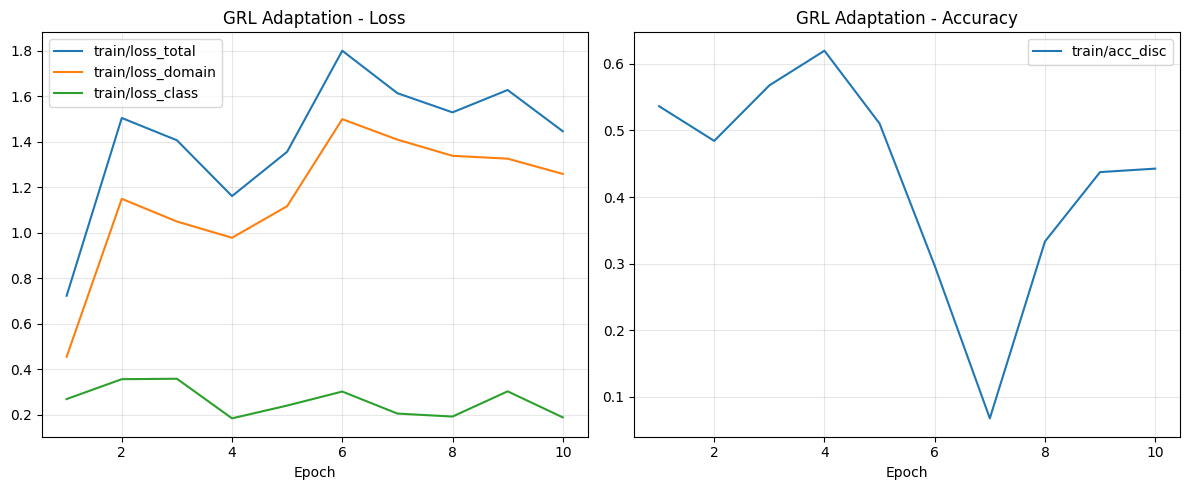

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



📝 Testing GRL on Target (MNIST-M)...


Output()


RESULTS SUMMARY:
Baseline: 0.6443
Oracle:   0.9521
GRL:      0.7554


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


In [17]:
# Initialize Model & Callback
grl_model = Net()
task_grl = DomainAdaptationTask(grl_model)
history_grl = MetricHistoryCallback()

logger_grl = WandbLogger(project="domain_adaptation_lab", name=f"grl")

trainer_grl = pl.Trainer(
    max_epochs=NUM_EPOCHS, 
    accelerator="auto",
    logger=logger_grl,
    callbacks=[history_grl],
    enable_checkpointing=False
)

print("🚀 Training GRL...")
trainer_grl.fit(task_grl, train_paired_loader)

# --- PLOT CURVES ---
plot_training_curves(history_grl.history, title="GRL Adaptation")

# Test
print("\n📝 Testing GRL on Target (MNIST-M)...")
res_grl = trainer_grl.test(task_grl, dataloaders=mnistm_test_loader, verbose=False)
acc_grl = res_grl[0]['test/acc']

print(f"\nRESULTS SUMMARY:\nBaseline: {acc_baseline:.4f}\nOracle:   {acc_oracle:.4f}\nGRL:      {acc_grl:.4f}")
wandb.finish()

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 5</b> Compare the training curves and final results with the reference notebook. Are they similar?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 6</b> 

<i>Comment on the training dinamics. What is happening?</i>

Your text

</div>

Let's visualize t-SNE:

Visualizing GRL Features (Adapted)...
Running t-SNE on 1024 samples...


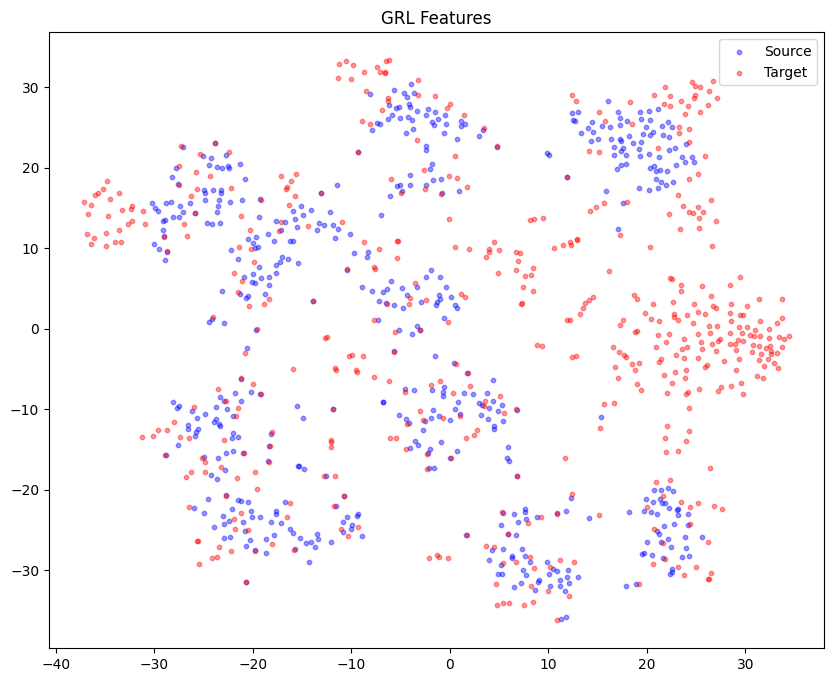

In [18]:
print("Visualizing GRL Features (Adapted)...")
visualize_tsne(grl_model.feature_extractor, mnist_test_loader, mnistm_test_loader, device, "GRL Features")

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 6</b> Compare the visualizations to the reference notebook. Are they similar?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 7</b> 

<i>What are the visualizations telling us? Are they coherent with the quantitative results? What is happening? Why?</i>

Your text

</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone 2</b> You successfully completed the second part!
</div>

## 🚀 Part 3: Extensions & Homework

Now that you have implemented GRL and compared it with the Baseline and Oracle, here are some challenging extensions to deepen your understanding of Domain Adaptation.

### 📝 1. Implement ADDA (Adversarial Discriminative Domain Adaptation)
GRL forces a *single* feature extractor to be domain-invariant. **ADDA** relaxes this by untying the weights.
* **Task:** Implement the ADDA pipeline.
    1.  **Pre-train** a Source Model (you can use your Baseline model).
    2.  **Initialize** a Target Model with Source weights.
    3.  **Adversarial Training:** Freeze the Source Model. Train the Target Model's encoder against a Discriminator to make Target features indistinguishable from Source features.
* **Comparison:** Does ADDA achieve higher accuracy than GRL on MNIST-M? (Literature suggests it often does because optimization is more stable).

### 🧪 2. Discrepancy-Based Methods (DeepCORAL or MMD)
Adversarial methods (like GRL/ADDA) can be unstable (min-max games). **Discrepancy-based** methods directly minimize a statistical distance between feature distributions.
* **Option A: DeepCORAL (Correlation Alignment):**
    * Compute the **Covariance Matrix** of the source batch ($C_S$) and target batch ($C_T$).
    * Add a loss term: $L_{CORAL} = || C_S - C_T ||_F^2$ (Frobenius norm).
    * *Why?* Aligning second-order statistics (covariance) often aligns the distributions well enough.
* **Option B: MMD (Maximum Mean Discrepancy):**
    * Use a Gaussian Kernel to compute the distance between the source and target feature means in a Reproducing Kernel Hilbert Space (RKHS).
    * Minimize $L_{MMD}$.

### 🛠️ 3. Hyperparameter Ablation & Stability
* **The Lambda Schedule ($\lambda$):** In GRL, we used a sigmoid schedule to slowly introduce the adversary.
    * **Experiment:** What happens if you set $\lambda=1.0$ from Epoch 0? Does the feature extractor collapse?
    * **Experiment:** Try a constant $\lambda=0.1$. Does it fail to align?
* **Network Depth:** We used a simple 2-layer CNN.
    * **Hypothesis:** Domain Adaptation works better on deeper networks (like ResNet-18) because they have more capacity to learn abstract, invariant features. Verify this by swapping `Net` for a small ResNet.

### ⏳ 4. Train for Convergence
* **Task:** We ran for only few epochs to save time. Re-run the **GRL** and **Baseline** experiments for **50 epochs**.
* **Question:** Does the GRL accuracy continue to climb, or does it plateau? Does the "Discriminator Accuracy" hover around 0.5 (perfect confusion) or does one side win?

---
**Submission:**
Please wrap up your code, ensure your WandB logs are synced (include the link in your notebook), and submit your `.ipynb` file via email.